   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


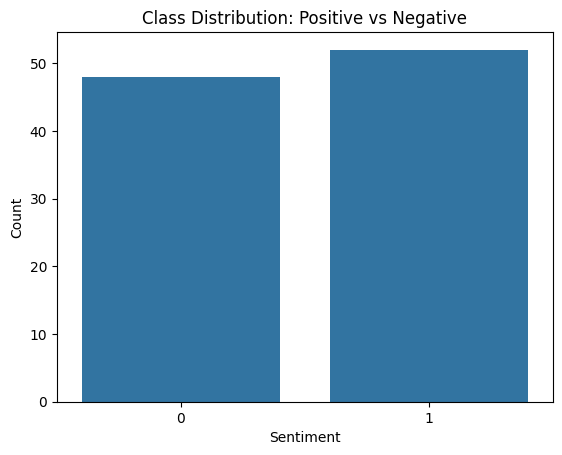

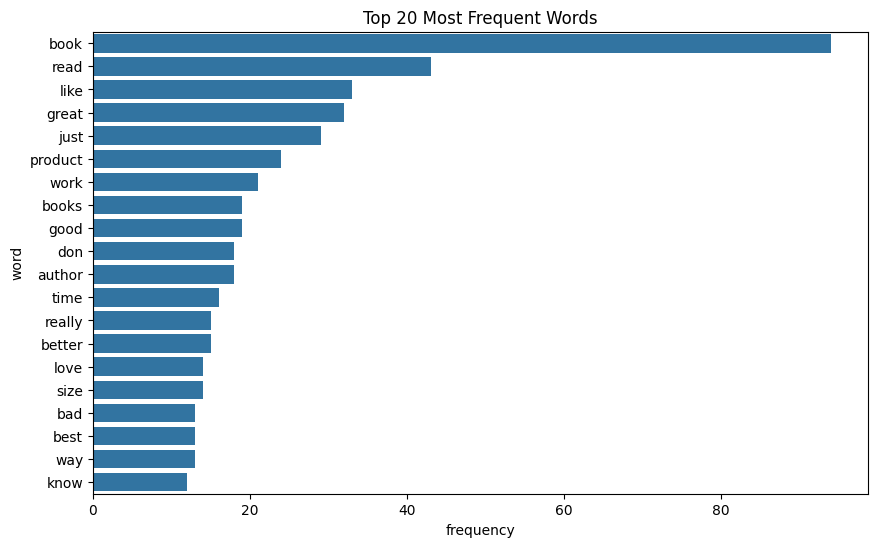

Epoch 1 — Loss: 0.6909
Epoch 2 — Loss: 0.6411
Epoch 3 — Loss: 0.5981
Epoch 4 — Loss: 0.5587
Epoch 5 — Loss: 0.5209

 Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.90      0.69      0.78        13

    accuracy                           0.75        20
   macro avg       0.75      0.77      0.74        20
weighted avg       0.80      0.75      0.76        20

 Accuracy: 0.75
 F1 Score: 0.7826


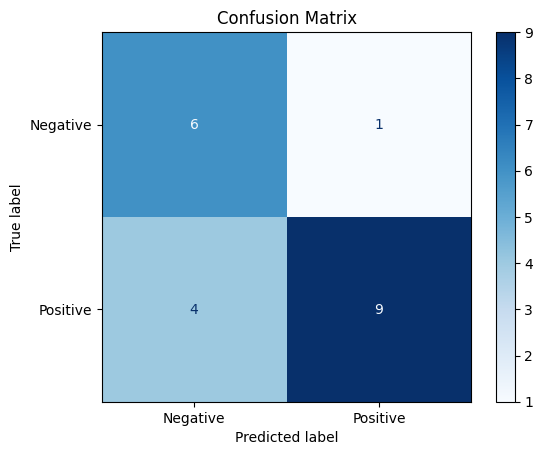

 ROC-AUC Score: 0.8352


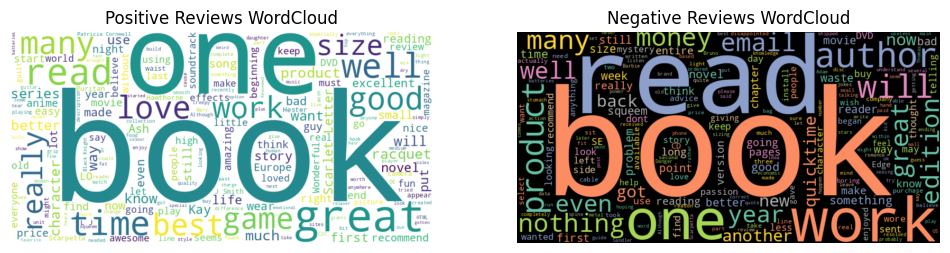

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da90a59aaec1906ef2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:

!pip install -q gradio wordcloud


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from wordcloud import WordCloud

# Load  dataset (sentiment_sample.csv )
df = pd.read_csv('sentiment_sample.csv')
df['text'] = df['text'].astype(str)
X = df['text'].values
y = df['sentiment'].values

# Visualize class distribution
sns.countplot(x=df['sentiment'])
plt.title("Class Distribution: Positive vs Negative")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Vectorize text (CountVectorizer)
vectorizer = CountVectorizer(max_features=3000, stop_words='english')
X_vec = vectorizer.fit_transform(X).toarray()

# Top 20 frequent words
word_freq = np.array(X_vec.sum(axis=0)).flatten()
vocab = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': vocab, 'frequency': word_freq})
top_words = freq_df.sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='frequency', y='word', data=top_words)
plt.title("Top 20 Most Frequent Words")
plt.show()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Build simple NN model
class SentimentNet(nn.Module):
    def __init__(self, input_dim):
        super(SentimentNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentNet(X_train.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

model.train()
for epoch in range(5):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} — Loss: {loss.item():.4f}")

# Evaluation
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = torch.argmax(outputs, axis=1).cpu().numpy()
    probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

print("\n Classification Report:\n", classification_report(y_test, predictions))
print(" Accuracy:", round(accuracy_score(y_test, predictions), 4))
print(" F1 Score:", round(f1_score(y_test, predictions), 4))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
auc = roc_auc_score(y_test, probabilities)
print(" ROC-AUC Score:", round(auc, 4))

# WordClouds
positive_texts = " ".join(df[df['sentiment'] == 1]['text'].tolist())
negative_texts = " ".join(df[df['sentiment'] == 0]['text'].tolist())

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(negative_texts)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")

plt.show()

# Gradio Demo
def predict_sentiment(text):
    vec = vectorizer.transform([text]).toarray()
    vec_tensor = torch.tensor(vec, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(vec_tensor)
        pred = torch.argmax(output, axis=1).item()
    return "Positive " if pred == 1 else "Negative "

gr.Interface(fn=predict_sentiment, inputs="text", outputs="text", title="Sentiment Classifier").launch()
